# Check performance of a RandomForest Regressor

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import storage
import nltk
from nltk.tokenize import RegexpTokenizer

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import layers
from keras import Model
from keras import Sequential
from keras import Input

import functions_14 as fn

%matplotlib inline

Using TensorFlow backend.


## Load data

In [2]:
# Load data
BUCKET_NAME = 'salary-data'
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)
df_train = pd.read_csv('gs://{}/{}'.format(BUCKET_NAME,'data_location_buckets.csv'))

In [3]:
# Select only relevant features
df_sub = df_train[['Title', 'FullDescription','ContractType', 'ContractTime', 'Company',
       'Category', 'TTWA_County','SalaryNormalized']]
df_sub.ContractType = df_sub.ContractType.fillna('Missing')
df_sub.ContractTime = df_sub.ContractTime.fillna('Missing')
df_sub.Company = df_sub.Company.fillna('Missing')
# Drop other NaN values
df_sub = df_sub.dropna()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Hot encode features

In [5]:
def hot_encode(df_variable):
    enc = OneHotEncoder()
    X = df_variable.values
    X = enc.fit_transform(X.reshape(-1, 1))
    return X

In [6]:
X_location = hot_encode(df_sub.TTWA_County)
X_contract_type = hot_encode(df_sub.ContractType)
X_contract_time = hot_encode(df_sub.ContractTime)
X_category = hot_encode(df_sub.Category) 
# Concatenate location, contract, and category
from scipy.sparse import hstack
X_one_hot = hstack((X_location,X_contract_type,X_contract_time,X_category))

## Or use pd.get_dummies

In [24]:
df_dum = pd.get_dummies(df_sub[['ContractType','ContractTime','Category', 'TTWA_County']])

## Create train/test split

In [45]:
y = df_sub.SalaryNormalized
# Create test split
X_train_full, X_test, y_train_full, y_test = train_test_split( df_dum, y, test_size=0.2, random_state=42)
# Create validation split
X_train, X_val, y_train, y_val = train_test_split( X_train_full, y_train_full, test_size=0.2, random_state=42)

## Build RF model

In [28]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators =500, random_state = 123, verbose = 0)
rfr.fit(X_train_full, y_train_full)

RandomForestRegressor(n_estimators=500, random_state=123)

In [33]:
from sklearn import metrics
size = 1000
y_pred = rfr.predict(X_test.values[:size,:])
print('RMSE: {}'.format(np.sqrt(metrics.mean_squared_error(y_test[:size], y_pred))))

RMSE: 14122.252170888487


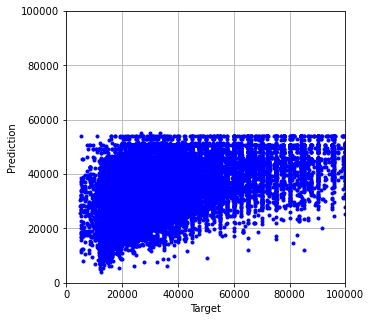

In [43]:
limits = [0, 100000]
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
ax.plot(y_test,y_pred,'b.')
ax.set_xlabel('Target')
ax.set_ylabel('Prediction')
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.grid()
plt.show()

## Compare performance to a Lin Reg

In [41]:
from sklearn import linear_model
lm = linear_model.LinearRegression() 
lm.fit(X_train_full, y_train_full)
y_pred = lm.predict(X_test)

In [42]:
print('RMSE: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

RMSE: 1695970766905877.8


## Compare performance to a MLP

In [132]:
def create_model():
    input_ = Input(shape=(X_train.shape[1]),)
    x = Dense(150, activation='relu')(input_)
    #x = Dense(100, activation='relu')(x)
    x = Dense(1, activation='linear')(x)
    x = Model(inputs=input_,outputs = x)
    x.compile(loss = 'mean_squared_error', optimizer = 'Adam')
    return x

In [140]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [143]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model = KerasRegressor(build_fn=create_model, verbose=0, epochs=5)
batch_size = [2,4,8,16,32]
param_grid = dict(batch_size = batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [118]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
epochs = 10
batch_size = 8
history = x.fit(X_train, y_train, epochs =epochs, batch_size = batch_size, verbose = 1, 
                validation_data = (X_val, y_val),
                callbacks = es)

Epoch 1/10
15672/15672 [==============================] - 44s 3ms/step - loss: 569186496.0000 - val_loss: 250105984.0000
Epoch 2/10
15672/15672 [==============================] - 42s 3ms/step - loss: 235528112.0000 - val_loss: 234697936.0000
Epoch 3/10
15672/15672 [==============================] - 43s 3ms/step - loss: 227767088.0000 - val_loss: 232016688.0000
Epoch 4/10
15672/15672 [==============================] - 43s 3ms/step - loss: 226059840.0000 - val_loss: 230870544.0000
Epoch 5/10
15672/15672 [==============================] - 42s 3ms/step - loss: 225378272.0000 - val_loss: 230472048.0000
Epoch 6/10
15672/15672 [==============================] - 42s 3ms/step - loss: 224989072.0000 - val_loss: 230205344.0000
Epoch 7/10
15672/15672 [==============================] - 44s 3ms/step - loss: 224676368.0000 - val_loss: 229943600.0000
Epoch 8/10
15672/15672 [==============================] - 43s 3ms/step - loss: 224359424.0000 - val_loss: 229638016.0000
Epoch 9/10
15672/15672 [========

In [119]:
loss = x.evaluate(X_test, y_test,verbose =1)
y_mean = np.mean(y_train)
rmse_mean = round(np.sqrt(np.mean((y_test-y_mean)**2)))
print("Mean RMSE = {}".format(rmse_mean))
print("Model RMSE = {}".format(round(np.sqrt(loss))))

1225/1225 [==============================] - 3s 2ms/step - loss: 223115008.0000
Mean RMSE = 17252
Model RMSE = 14937


In [120]:
y_pred = x.predict(X_test,verbose = 1)

1225/1225 [==============================] - 2s 1ms/step


In [121]:
loss_rmse = np.sqrt(history.history['loss'])
val_loss_rmse = np.sqrt(history.history['val_loss'])

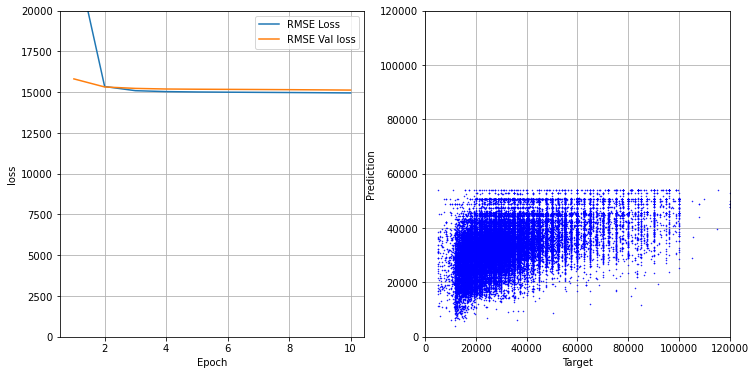

In [122]:
limit_1 = [0, 20000]
limit_2 = [0, 120000]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
ax1.plot(range(1,epochs+1),loss_rmse,label = 'RMSE Loss')
ax1.plot(range(1,epochs+1),val_loss_rmse, label = 'RMSE Val loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(limit_1)
ax1.legend()
ax1.grid()

ax2.plot(y_test,y_pred,'b.', markersize=1 )
ax2.set_xlim(limit_2)
ax2.set_ylim(limit_2)
ax2.set_xlabel('Target')
ax2.set_ylabel('Prediction')
ax2.grid()
plt.show()